#데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path1='/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/excel 파일/lstm/data0826.xlsx'

In [ ]:
data= pd.read_excel(path1)

In [ ]:
data.columns

Index(['x_1-0', 'y_1-0', 'x_2-1', 'y_2-1', 'x_3-2', 'y_3-2', 'x_4-3', 'y_4-3',
       'x_5-4', 'y_5-4', 'x_6-5', 'y_6-5', 'x_7-6', 'y_7-6', 'x_8-7', 'y_8-7',
       'x_9-8', 'y_9-8', 'x_10-9', 'y_10-9', 'x_11-10', 'y_11-10', 'x_12-11',
       'y_12-11', 'x_13-12', 'y_13-12', 'x_14-13', 'y_14-13', 'x_15-14',
       'y_15-14', 'x_16-15', 'y_16-15', 'd_ratio', 'd_ratio_sq', 'sin dif',
       '엄지 중지 내적', '검지 중지 내적', 'y', 'id', 'time'],
      dtype='object')

#LSTM-AE

##train-test 데이터셋 분리

In [ ]:
vector0 = data[data["y"]==0].sort_values(by=['id','time'])
vector0.reset_index(drop=True, inplace=True)
vector0.drop(['y'],axis=1, inplace=True)

In [ ]:
vector1 = data[data["y"]==1].sort_values(by=['id','time'])
vector1.reset_index(drop=True, inplace=True)
vector1.drop(['y'],axis=1, inplace=True)

In [ ]:
vector1[vector1.id == 45].index[0]

1024

In [ ]:
x0_test = vector0
x1_train = vector1[:1024]
x1_test = vector1[1024:]

In [ ]:
len(x1_train)

1024

In [ ]:
len(x1_test)

352

In [ ]:
len(x0_test)

416

In [ ]:
x1_train = np.array(x1_train)

비정상 :1, 정상: 0 으로 testset 구성

In [ ]:
x0_test = np.array(x0_test)
x1_test = np.array(x1_test)

In [ ]:
x00_test_tot = np.hstack((x0_test, np.ones(x0_test.shape[0]).reshape(-1,1)))
x11_test_tot = np.hstack((x1_test, np.zeros(x1_test.shape[0]).reshape(-1,1)))
test = np.vstack((x00_test_tot, x11_test_tot))

In [ ]:
x1_train = x1_train[:,:-2]
x_test = test[:,:-3]
y_test = test[:,-1]

In [ ]:
print(x1_train.shape,x_test.shape)

(1024, 37) (768, 37)


In [ ]:
import tensorflow as tf

In [ ]:
x1_train=tf.reshape(x1_train,[-1, 32, x1_train.shape[1]]) # 마지막은 열 개수
print(x1_train.shape)

x_test=tf.reshape(x_test,[-1, 32, x_test.shape[1]]) # 마지막은 열 개수
print(x_test.shape)

(32, 32, 37)
(24, 32, 37)


##신경망 구축

In [ ]:
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2])) #개수, 열
    # return_sequences 가 True면 각 time_steps의 셀이 모두 출력으로 내보냄 , False 면 최종 셀만 출력으로 내보냄
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = autoencoder_model(x1_train)
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "model_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       [(None, 32, 37)]          0         
_________________________________________________________________
lstm_576 (LSTM)              (None, 32, 32)            8960      
_________________________________________________________________
lstm_577 (LSTM)              (None, 16)                3136      
_________________________________________________________________
repeat_vector_144 (RepeatVec (None, 32, 16)            0         
_________________________________________________________________
lstm_578 (LSTM)              (None, 32, 16)            2112      
_________________________________________________________________
lstm_579 (LSTM)              (None, 32, 32)            6272      
_________________________________________________________________
time_distributed_144 (TimeDi (None, 32, 37)            12

In [ ]:
model = autoencoder_model(x1_train)
model.compile(optimizer='adam',loss='mse')

In [ ]:
epochs=100
batch_size=10
callbacks=[EarlyStopping(monitor='val_loss',patience=5)]
history = model.fit(x1_train, x1_train, epochs=epochs, batch_size= batch_size,callbacks = callbacks, validation_split=0.05).history

Epoch 1/100
3/3 [==============================] - 4s 357ms/step - loss: 26.3233 - val_loss: 3.0286
Epoch 2/100
3/3 [==============================] - 0s 48ms/step - loss: 17.3466 - val_loss: 2.8564
Epoch 3/100
3/3 [==============================] - 0s 47ms/step - loss: 14.7163 - val_loss: 2.8015
Epoch 4/100
3/3 [==============================] - 0s 54ms/step - loss: 14.5148 - val_loss: 2.7655
Epoch 5/100
3/3 [==============================] - 0s 47ms/step - loss: 14.4698 - val_loss: 2.7300
Epoch 6/100
3/3 [==============================] - 0s 49ms/step - loss: 14.4302 - val_loss: 2.6951
Epoch 7/100
3/3 [==============================] - 0s 52ms/step - loss: 14.3844 - val_loss: 2.6558
Epoch 8/100
3/3 [==============================] - 0s 51ms/step - loss: 14.3397 - val_loss: 2.6079
Epoch 9/100
3/3 [==============================] - 0s 49ms/step - loss: 14.2870 - val_loss: 2.5432
Epoch 10/100
3/3 [==============================] - 0s 49ms/step - loss: 14.3069 - val_loss: 2.4980
Epoch 11

In [ ]:
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

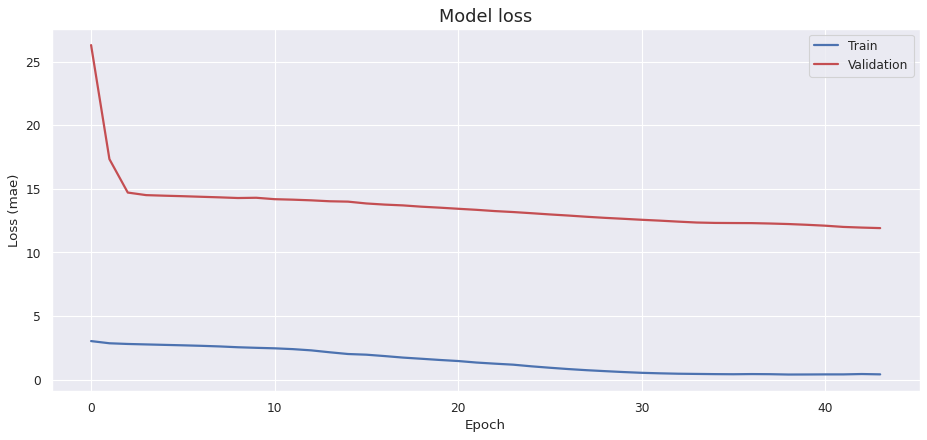

In [ ]:
# 학습 손실 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['val_loss'], 'b', label='Train', linewidth=2)
ax.plot(history['loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

재구성손실값도출

In [ ]:
from sklearn import metrics

     Reconstruction_error  True_class
0                1.408146         1.0
1                1.467318         1.0
2                1.036776         1.0
3                0.823462         1.0
4                0.607674         1.0
..                    ...         ...
763              0.204944         0.0
764              0.227898         0.0
765              0.258377         0.0
766              0.197748         0.0
767              0.219638         0.0

[768 rows x 2 columns]
299
precision:  0.8004807692307693 , recall:  0.8004807692307693
threshold:  0.7869603714148776


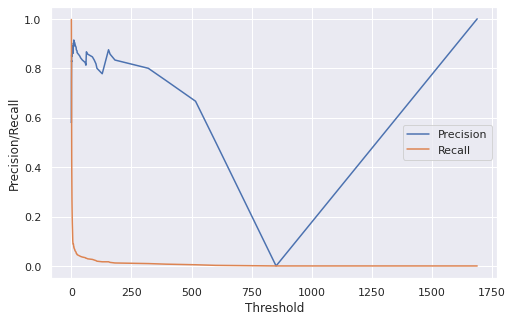

In [ ]:
#TEST 데이터 입력
test_predictions_3d = model.predict(x_test)
test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0]*test_predictions_3d.shape[1], test_predictions_3d.shape[2])
x_test_ = np.array(x_test).reshape(x_test.shape[0]*x_test.shape[1], x_test.shape[2])

#재구성 손실 값 도출
mse = np.mean(np.power(x_test_ - test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class': y_test})

print(error_df)

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error']) ##auc curve 사용 말고 다른 방법

#모델 최적의 threshold 값 찾기
best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]  #둘의 차가 최소가 될때가 threshold

print(np.argmin(best_cnt_dic))
print('precision: ', precision_rt[np.argmin(best_cnt_dic)], ', recall: ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label = 'Precision')
plt.plot(threshold_rt, recall_rt[1:], label = 'Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

모델 성능 평가

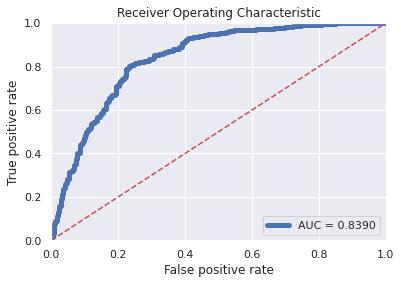

In [ ]:
from sklearn.metrics import roc_curve, auc

#fpr, tpr, thresholds = roc_curve(y_valid, mse)

fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc, linewidth=5)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

예측값

In [ ]:
test_predictions_3d = model.predict(x_test)

test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0]*test_predictions_3d.shape[1], test_predictions_3d.shape[2])
x_test_ = np.array(x_test).reshape(x_test.shape[0]*x_test.shape[1], x_test.shape[2])
mse = np.mean(np.power(x_test_ - test_predictions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})
print(error_df)

pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

     Reconstruction_error  True_class
0                1.408146         1.0
1                1.467318         1.0
2                1.036776         1.0
3                0.823462         1.0
4                0.607674         1.0
..                    ...         ...
763              0.204944         0.0
764              0.227898         0.0
765              0.258377         0.0
766              0.197748         0.0
767              0.219638         0.0

[768 rows x 2 columns]


In [ ]:
def list_chunk(lst):
    return [lst[i:i+32] for i in range(0, len(lst), 32)]

pred_y_32 = list_chunk(pred_y)
print("분할 후 : ", pred_y_32)

pred_y_32 = np.mean(np.array(pred_y_32), axis=1)
print("중간 예측 값 : ", pred_y_32)

pred_y = list()
for i in range(len(pred_y_32)):
  if pred_y_32[i] >= 0.50:
    pred_y.append(1)
  else:
    pred_y.append(0)

print("최종 예측 값 : ", pred_y)

분할 후 :  [[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1], [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], [1, 1, 1, 1

accuracy:  [0.79166667]


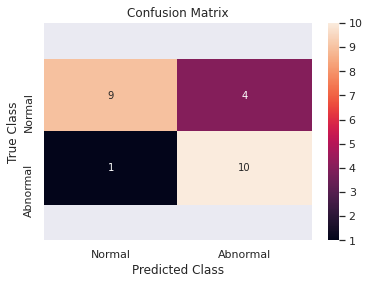

In [ ]:
true_class = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0]

conf_matrix = metrics.confusion_matrix(true_class, pred_y)

accuracy = (conf_matrix[0][0]+ conf_matrix[1][[1]])/conf_matrix.sum()
print('accuracy: ',accuracy)

sns.heatmap(conf_matrix, xticklabels=['Normal','Abnormal'], yticklabels=['Normal', 'Abnormal'], annot=True, fmt='d', annot_kws={'size':10})
b,t = plt.ylim()
b+=0.5
t-=0.5
plt.ylim(b,t)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

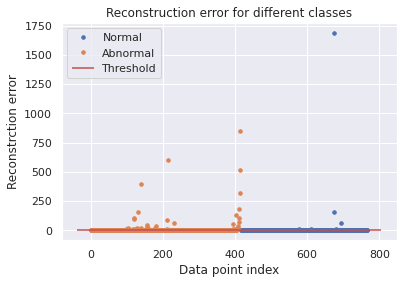

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
  ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms=3.5, linestyle='',
          label='Abnormal' if name ==1 else 'Normal')

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors ='r', zorder=100, label ='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")  
plt.ylabel("Reconstrction error")
plt.xlabel("Data point index")
plt.show()

#새로운 데이터 입력

In [ ]:
path2='/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/excel 파일/preprocessing/finaldata_0824_nu_correct7.xlsx'

In [ ]:
testdata = pd.read_excel(path2)
testdata
new_x1 = testdata.drop(['y','image'], axis=1)
new_x1 = new_x1[0:32]

new_x1 = np.array(new_x1)
new_x1 = tf.reshape(x1_train,[-1,32,new_x1.shape[1]])

In [ ]:
test_predictions_3d = model.predict(new_x1)
test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0]*test_predictions_3d.shape[1], test_predictions_3d.shape[2])
x_test_ = new_x1.reshape(new_x1.shape[0]*new_x1.shape[1], new_x1.shape[2])
mse = np.mean(np.power(x_test_ - test_predictions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse})

#print(error_df)

pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

#print(pred_y)

correct=0
notcorrect=0
for i in pred_y:
  if i == 0 :
    correct+=1
  else:
    notcorrect+=1

ratio_o=correct/len(pred_y)
ratio_x=notcorrect/len(pred_y)
if correct > notcorrect :
  print("{0:0.3f} :: 올바른 젓가락질입니다.".format(ratio_o))
elif correct == notcorrect:
  print("재촬영해주세요")
else:
  print("{0:0.3f} :: 올바르지 않은 젓가락질입니다.".format(ratio_x))

#모델 저장

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp05at5odi/assets


INFO:tensorflow:Assets written to: /tmp/tmp05at5odi/assets


In [ ]:
#저장
open('LSTM_AE.tflite', 'wb').write(tflite_model)

133816